## Multi Agent Deep RL Tennis - How it works and what it does

Unity ML-Agents Toolkit provides a variety of open-source 3D environments that can be used to train an intelligent agent. In this project we'll look at the multi agent Tennis environment. The objective is to have 2 paddles bounce a ball back and forth, without letting it hit the ground or sending it out of bounds.


### Learning Algorithm

The learning algorithm being used is based on MADDPG, a multi agent capable version of DDPG, training each agent to compete against the other. The idea behind DDPD/MADDPG is to apply the success of the DQN to continuous actions, something that DQN was not designed to achieve. The researchers behind DDPG were able to solve more than 20 simulated physics tasks with no changes to hyperparameters of their network, demonstrating impressive performance.

The MADDPG algorithm uses what are known as actor and critic neural nets to achieve continuous actions, and each agent learns its own actor and critic networks as it plays against the opponent. The actor network predicts the best action and the critic network predicts what the value of that action will be. Considering the success of DQN however and borrowing an idea from there, DDPG also utilizes target networks to stabilize the training which the DDPG team actually described in their paper as being 'crucial'.

To cement my understanding I read a lot of online content like blogs, reviewed code written by other people, and read the original research paper.

- https://arxiv.org/pdf/1706.02275.pdf
- https://www.katnoria.com/maddpg/
- https://github.com/katnoria/unityml-tennis/tree/a056fb897200f97d63bef15fda0218ae7941b573
- https://github.com/openai/maddpg
- https://github.com/kotogasy/unity-ml-tennis

This implementation is based on the DDPG implementation from the last project, the code provided in the MADDPG lab exercise, and several online resources.


##### Actor network
This actor network is based on the same that I used in the DDPG project. I achieved reasonable results with that architecture on the Reacher environment and so carried it over to MADDPG.

The actor network is implemented as follows, where state_size is the size of the environment state (33 for Reacher), the output action_size is the number of actions available to the agent (4 for Reacher) and all hidden layers have 128 nodes. 

This number of hidden nodes was found through trial and error and was found to solve the environment in fewer episodes than other configurations. In the DDPG paper they mention they used 2 hidden layers, as I do here, however they used 400 units on the first and 300 units on the second hidden layers whereas I am using 128 nodes for all hidden layers.
    - self.fc1 = nn.Linear(state_size, hidden)
    - self.bn1 = nn.BatchNorm1d(hidden)
    - self.fc2 = nn.Linear(hidden, hidden)
    - self.fc3 = nn.Linear(hidden, action_size)
    
##### Critic network
This critic network is based on the same that I used in the DDPG project. I achieved reasonable results with that architecture on the Reacher environment and so carried it over to MADDPG.

The critic network is very similar to the one described in the DDPG paper however during experimenting I made a few changes, and ultimately decided on the following architecture. Just like the network described in the DDPG paper, here the actions are being concatenated as input after the first hidden layer, as opposed to including it with the input to the network.
    - self.fc1 = nn.Linear(state_size, hidden)
    - self.bn1 = nn.BatchNorm1d(hidden)
    - self.fc2 = nn.Linear(hidden+action_size, hidden)
    - self.fc3 = nn.Linear(hidden, hidden)
    - self.fc4 = nn.Linear(hidden, 1)

These networks also use the 'fan-in' type initialization mentioned in the Experiment Details section of the DDPG paper.


##### Noise generator
While reading the OpenAI Spinning Up page about DDPG they mentioned that basic gaussian noise was often just as good in practice as the OU noise used in the DDPG paper. I decided to experiment a bit and try gaussian noise, which seems to have worked just fine to solve the environment. I also introduced a decay factor so the agent would take fewer exploratory actions as it learned a better policy, the noise method may not be the best option available, but was a fun experiment and still does the trick.

The noise function for gaussian noise is straightforward in numpy, where the scale parameter is the standard deviation of the distribution of the noise and size is the size of the output and dictated by the action space (4 for Reacher).
    - noise = np.random.normal(loc=0.0, scale=self.scale, size=self.size)
   
##### Hyperparameter choices
To select the hyperparameters to train the network I used a mix of trial and error and best-practice suggestions. 

The BUFFER_SIZE And BATCH_SIZE parameters were selected through trial and error and were found to enable stable training. The parameter GAMMA it typically set to 0.99 so I continued with that choice, TAU is the soft update parameter determining how much of the local weights to copy to the target network, and uses a slightly higher value than the LR learning rate parameter for training the network via gradient descent. The UPDATE_EVERY and LEARN_TIMES parameters were found through trial and error, it was a challenge to find paratemers that worked well for this environment due to the time needed to test each change.

    - BUFFER_SIZE = 200000    # replay buffer size
    - BATCH_SIZE = 256        # minibatch size
    - GAMMA = 0.99            # discount factor
    - TAU = 1e-2              # for soft update of target parameters
    - LR = 0.001              # learning rate for the actor and critic networks
    - UPDATE_EVERY = 4        # how often to update the network
    - LEARN_TIMES = 16        # how many batches to sample and learn from 
    
##### Ideas for Future Improvements
There are many things you could do to improve the performance of this algorithm. 

Prioritized replay could be used to enhance the speed of training and skill of the trained agent, this is a nice low-hanging-fruit type of improvement that would be a sendible next step to improve the agent. The review of my last project suggested a code repo with PER implemented however I did not try to use that for this project. 

In the MADDPG paper they send additional state to the critic networks to assist with training, however my implementation uses the vanilla DDPG update logic and the critic networks do not share any state information. Another improvement would be to use the same update logic for critic network that is used in the MADDPG paper, as opposed to this simpler approach that simply uses 2 DDPG agents. 

Or we could try out a different algorithm entirely, multi-agent PPO would be another good choice for this environment.

The hyper parameters could likely use some additional tweaking too, but it's very time consuming to test those changes so I've settled with the first set of parameters that I found working.


### Let's train an agent!

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from maddpg_agent import MADDPG
from unityagents import UnityEnvironment

%matplotlib inline
plt.ion()

def new_unity_environment(train_mode=True):
    env = UnityEnvironment(file_name=".//Tennis_Windows_x86_64//Tennis.exe")
    
    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    
    # reset the environment
    env_info = env.reset(train_mode=train_mode)[brain_name] 
    
    # get the current state
    state = env_info.vector_observations[0]
    
    # look up the size of the action and state spaces
    state_size = env_info.vector_observations[0].shape[0]
    action_size = brain.vector_action_space_size
    
    return (brain_name, env, env_info, state, state_size, action_size)


def maddpg_train(maddpg, env, brain_name, state_size, train_mode=True, n_episodes=10000, max_t=1000):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    for i_episode in range(1, n_episodes+1):
        # reset the environment for the start of a new episode
        env_info = env.reset(train_mode=train_mode)[brain_name] 
        
        # get the current state for all agents
        state = env_info.vector_observations
        
        # the score each episode starts at zero
        score = 0
        
        for t in range(max_t):
            actions = maddpg.act(state, add_noise=True)
            env_info = env.step(actions)[brain_name] # containing actions for both agents
            next_state = env_info.vector_observations # next states for both agents
            rewards = env_info.rewards  # rewards for both agents
            dones = env_info.local_done # done status for both agents
            score += max(rewards)       # take only the highest score 
            maddpg.step(state, actions, rewards, next_state, dones)
            state = next_state
            if any(dones):  # if either agent is done, you're done!
                break 
            
        scores_window.append(score)       # save most recent max score
        scores.append(score)              
        mean_score = np.mean(scores_window)
                
        print('\rEpisode {}\tAverage Score: {:.2f}\tActual Score:{:.2f}'.format(i_episode, mean_score, score), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tActual Score:{:.2f}'.format(i_episode, mean_score, score))
        if np.mean(scores_window)>=0.50:  # solved is 0.5
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tActual Score:{:.2f}'.format(i_episode, mean_score, score))
            for i, agent in enumerate(maddpg.agents):
                torch.save(agent.actor_local.state_dict(), 'Z:/{:.2f}_actor_{}_checkpoint.pth'.format(mean_score, i))
            break  # or not and just keep on keepin on
            
    return scores


In [1]:

brain_name, env, env_info, state, state_size, action_size = new_unity_environment(train_mode=True)
maddpg = MADDPG(state_size, action_size, 1337)
scores = maddpg_train(maddpg, env, brain_name, state_size, train_mode=True)
env.close()


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Episode 10	Average Score: 0.01	Actual Score:0.00
Episode 20	Average Score: 0.03	Actual Score:0.10
Episode 30	Average Score: 0.02	Actual Score:0.00
Episode 40	Average Score: 0.02	Actual Score:0.00
Episode 50	Average Score: 0.02	Actual Score:0.00
Episode 60	Average Score: 0.02	Actual Score:0.00
Episode 70	Average Score: 0.02	Actual Score:0.00
Episode 80	Average Score: 0.02	Actual Score:0.00
Episode 90	Average Score: 0.02	Actual Score:0.00
Episode 100	Average Score: 0.02	Actual Score:0.00
Episode 110	Average Score: 0.02	Actual Score:0.00
Episode 120	Average Score: 0.02	Actual Score:0.00
Episode 130	Average Score: 0.02	Actual Score:0.00
Episode 140	Average Score: 0.03	Actual Score:0.00
Episode 150	Average Score: 0.03	Actual Score:0.00
Episode 160	Average Score: 0.03	Actual Score:0.00
Episode 170	Average Score: 0.03	Actual Score:0.10
Episode 180	Average Score: 0.03	Actual Score:0.00
Episode 190	Average Score: 0.03	Actual Score:0.00
Episode 200	Average Score: 0.03	Actual Score:0.00
Episode 2

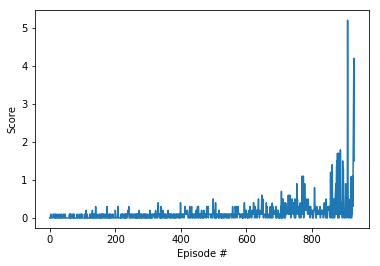

In [2]:
# plot the scores after training to a 100 episode average score of 0.5
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch a trained agent!

Run the code cell below to watch a trained agent in the Unity environment. We'll load the saved weights for the actor networks, copy those weights into the corresponding target networks, then start up the agent and watch it perform.

Run the next code cell to see the trained agent in action!

In [2]:
import torch
import matplotlib.pyplot as plt
from maddpg_agent import  MADDPG
from unityagents import UnityEnvironment

%matplotlib inline
plt.ion()

# create the new unity environment
brain_name, env, env_info, state, state_size, action_size = new_unity_environment(train_mode=False)

# create an instance of the 2 agent algorithm
maddpg_agent = MADDPG(state_size=state_size, action_size=action_size)

# for each agent, load its saved weights
maddpg_agent.agents[0].actor_local.load_state_dict(torch.load('./0.50_actor_0_checkpoint.pth'))
maddpg_agent.agents[1].actor_local.load_state_dict(torch.load('./0.50_actor_1_checkpoint.pth'))

maddpg_agent.agents[0].copy_weights_from_local_to_target()
maddpg_agent.agents[1].copy_weights_from_local_to_target()

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations               # get the current state
score = 0                                          # initialize the score

# watch a trained agent!
while True:
    actions = maddpg_agent.act(state, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_state = env_info.vector_observations
    rewards = env_info.rewards  
    dones = env_info.local_done 
    score += max(rewards)       # take only the highest score
    maddpg_agent.step(state, actions, rewards, next_state, dones)
    state = next_state
    
    if any(dones):  # if either agent is done, you're done!
        env.close()
        break
    
print("Score: {}".format(score))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Score: 0.7000000104308128
